# Airbnb Data Analyses 
<br>New York City Airbnb data are from http://insideairbnb.com/get-the-data.html
<br>Date download: 2/16/2020
<br>Author: Chen Li 
<br>Email: lichen1210@gmail.com
<br>Code Created on : 2/16/2020
<br>Code Last Updated on: 2/25/2020

### 1. Data Exploration and Cleaning

In [1]:
# import commonly used packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
listing_all = pd.read_csv('listings_raw.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
listing_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 40.9+ MB


In [4]:
# data cleaning tracker 
dat_clean = pd.DataFrame({'ord':0,
                         'action':'start', 
                         'nrow_after': listing_all.shape[0],
                         'ncol_after':listing_all.shape[1],
                         'nrow_changed':np.nan, 
                         'ncol_changed':np.nan }, index = [0])
print(dat_clean)

   ord action  nrow_after  ncol_after  nrow_changed  ncol_changed
0    0  start       50599         106           NaN           NaN


#### 1) Remove url features

In [5]:
# remove the columns that are urls, as they are less informative 
all_columns = listing_all.columns.to_list()
boo_nourl = [True if 'url' not in x else False for x in all_columns]; len(boo_nourl)
boo_nourl.count(False)# 8, will remove 8 columns 

listing_all = listing_all[list(np.array(all_columns)[np.array(boo_nourl)])];
listing_all.shape

(50599, 98)

In [6]:
# update the data cleaning log 
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'remove features of urls', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after'] ),
                                     dat_clean.columns[5]:(listing_all.shape[1]) - dat_clean.loc[max(dat_clean.index), 'ncol_after']}, index = [max(dat_clean.index)+1]))


In [7]:
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0


#### 2) Examine and remove features with more than 40% missing 

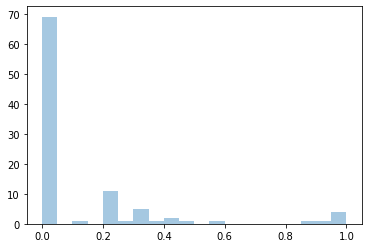

In [8]:
# Remove features with too much missing. 
null_sum = listing_all.isnull().mean().sort_values()
sns.distplot(null_sum, kde = False, bins = 20);
## Appoximately, 70 features do not have missing values. 

In [9]:
null_sum[null_sum>0.4]

host_about              0.400996
interaction             0.405660
access                  0.465286
notes                   0.592423
weekly_price            0.888259
monthly_price           0.902844
square_feet             0.992371
license                 0.999565
jurisdiction_names      0.999684
host_acceptance_rate    1.000000
dtype: float64

In [10]:
listing_all['jurisdiction_names'][~listing_all['jurisdiction_names'].isnull()].head()
# Without a codebook and so many missing values, remove feature 'jurisdiction_names'

3686      {"Rensselaer County"," NY"}
19425           {"Connecticut State"}
24866        {"South Carolina State"}
25125            {"New Jersey State"}
25400    {"Westchester County"," NY"}
Name: jurisdiction_names, dtype: object

In [11]:
listing_all['license'][~listing_all['license'].isnull()].head()
# too many missing and does not make immediate sense, remove 'license'.

27064    35-2593481
30356    81-1092926
30357    81-1092926
30358    81-1092926
30359    81-1092926
Name: license, dtype: object

1      500.0
10     500.0
14     750.0
17    2160.0
19     800.0
Name: square_feet, dtype: float64
Only 386 listings has the square feet measure.


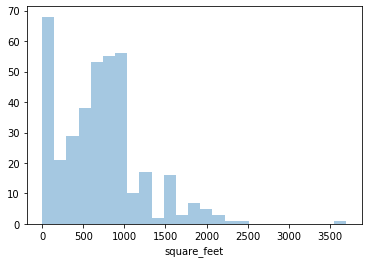

In [12]:
print(listing_all['square_feet'][~listing_all['square_feet'].isnull()].head())
sns.distplot(listing_all['square_feet'][~listing_all['square_feet'].isnull()], kde=False)
print('Only '+ str(len(listing_all['square_feet'][~listing_all['square_feet'].isnull()])) + ' listings has the square feet measure.') # 386
# too many missing. Among the 386 non-null values, there are 70 (approcimate) list their square feet as 0.
# If create binary feature to indicate whether square_feet is listed, the recoded feature will have a extremely small variance, which contributes little to prediction
# remove 'sqare_feet'

In [13]:
listing_all['notes'][~listing_all['notes'].isnull()].head()
# hard to process, too much missing 
# remove 'notes'

2    Read My Full Listing For All Information. New ...
4    Reservation should be made at least a few days...
5    Because we are an active family, I guarantee t...
6    This is my personal apartment. It's not a busi...
7    I do the daily recycling for the apartment. I ...
Name: notes, dtype: object

In [14]:
from re import sub
from decimal import Decimal

count     5654.000000
mean       890.337283
std        799.755626
min         85.000000
25%        470.000000
50%        700.000000
75%       1050.000000
max      14000.000000
Name: weekly_price, dtype: float64

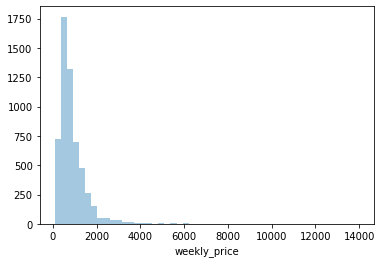

In [15]:
weekly_price_num = listing_all['weekly_price'][~listing_all['weekly_price'].isnull()].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))
sns.distplot(weekly_price_num.astype(float), kde=False)
weekly_price_num.astype(float).describe()

In [16]:
aaa = listing_all[['price','weekly_price']][~listing_all['weekly_price'].isnull()]
diff_weekly = aaa['price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))*7-aaa['weekly_price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))
diff_weekly.astype(float).describe()
# weekly price is not always a consistent discounted price, not very useful

count     5654.000000
mean       104.789353
std       1203.148739
min     -10950.000000
25%        -35.000000
50%         53.000000
75%        164.000000
max      69655.000000
dtype: float64

count     4916.000000
mean      2932.860252
std       2539.567001
min        455.000000
25%       1500.000000
50%       2400.000000
75%       3500.000000
max      45000.000000
Name: monthly_price, dtype: float64

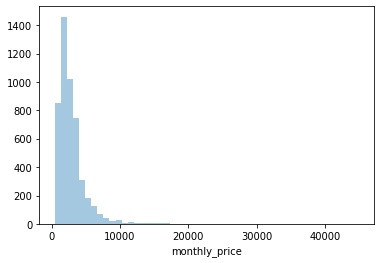

In [17]:
monthly_price_num = listing_all['monthly_price'][~listing_all['monthly_price'].isnull()].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))
sns.distplot(monthly_price_num.astype(float), kde=False)
monthly_price_num.astype(float).describe()

In [18]:
bbb = listing_all[['price','monthly_price']][~listing_all['monthly_price'].isnull()]
diff_monthly = (bbb['price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))*30-bbb['monthly_price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x))))
diff_weekly.astype(float).describe()
# monthly price is not always a consistent discounted price, not very useful

count     5654.000000
mean       104.789353
std       1203.148739
min     -10950.000000
25%        -35.000000
50%         53.000000
75%        164.000000
max      69655.000000
dtype: float64

In [19]:
listing_all['access'][~listing_all['access'].isnull()].head()
# too much missing, and too hard to be informative 
# remove

0    Guests have full access to the kitchen, bathro...
1    You will have exclusive use of and access to: ...
2                        I will meet you upon arrival.
4    Bathroom is shared with the host but the kitch...
5    Guests will be able to come and go as they nee...
Name: access, dtype: object

In [20]:
listing_all['interaction'][~listing_all['interaction'].isnull()].head()
# too much missing, and too hard to be informative 
# remove

0    I am a Sound Therapy Practitioner and Kundalin...
1    We'll be around, but since you have the top fl...
2    I usually check in with guests via text or ema...
5    My modern family is super busy with lots of co...
6    This listing is for the whole apartment I will...
Name: interaction, dtype: object

In [21]:
listing_all['host_about'][~listing_all['host_about'].isnull()].head()
# too much missing, and too hard to be informative 
# remove

0    A New Yorker since 2000! My passion is creatin...
1       Laid-back bi-coastal actor/professor/attorney.
2    I'm an artist, writer, traveler, and a native ...
3     I am an artist(painter, filmmaker) and curato...
4    I used to work for a financial industry but no...
Name: host_about, dtype: object

In [22]:
# To conclude remove 'host_about' 'interaction' 'access' 'notes' 'square_feet' 'license' 'jurisdiction_names'  'host_acceptance_rate' 'monthly_price' 'weekly_price'
listing_all = listing_all.drop(labels = ['host_about','interaction','access','notes','square_feet','license','jurisdiction_names','host_acceptance_rate', 'weekly_price', 'monthly_price'], axis = 1)


In [23]:
# update the data cleaning log 
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'remove features with more than 40% of missing', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0]-dat_clean.loc[max(dat_clean.index), 'nrow_after']),
                                     dat_clean.columns[5]:(listing_all.shape[1]-dat_clean.loc[max(dat_clean.index), 'ncol_after'])}, index = [max(dat_clean.index)+1]))


In [24]:
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0
2,2,remove features with more than 40% of missing,50599,88,0.0,-10.0


#### 3) Remove features has no variability

In [25]:
#indentifies features with no variance, that is none informative to analysis.
no_variance = []
for col in listing_all.columns:
    freq = listing_all[col].value_counts().index.unique()
    if len(freq)==1:
        print([col, freq])
        no_variance.append(col)

['scrape_id', Int64Index([20191204162729], dtype='int64')]
['experiences_offered', Index(['none'], dtype='object')]
['country_code', Index(['US'], dtype='object')]
['country', Index(['United States'], dtype='object')]
['has_availability', Index(['t'], dtype='object')]
['requires_license', Index(['f'], dtype='object')]
['is_business_travel_ready', Index(['f'], dtype='object')]


In [26]:
# remove feature with identical values
listing_all = listing_all.drop(labels = no_variance, axis = 1)

In [27]:
# update the data cleaning log 
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'remove features with no variance', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after']),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'])}, index = [max(dat_clean.index)+1]))


#### 4) Recode variables <i>object</i> type to <i>numeric</i>

In [28]:
listing_objfeat = listing_all.select_dtypes(include=['object'])

##### Strip out the numeric amount for all prices 

In [29]:
money_feat = ['price', 'security_deposit','cleaning_fee', 'extra_people']
# It is reasonable to assume if NA in security_deposit or cleaning_fee is NA
listing_all[['security_deposit','cleaning_fee']] = listing_all[['security_deposit','cleaning_fee']].fillna('$0')
listing_all[money_feat].isnull().sum()

price               0
security_deposit    0
cleaning_fee        0
extra_people        0
dtype: int64

In [30]:
for feat in money_feat:
    listing_all[feat] = listing_all[feat].apply(lambda x: float(Decimal(sub(r'[^\d.]', '', str(x)))))

In [31]:
listing_all[money_feat].describe()

,price,security_deposit,cleaning_fee,extra_people
count,50599.000000,50599.000000,50599.000000,50599.000000
mean,158.171782,176.433289,53.181011,14.396806
std,348.089562,436.387978,58.112137,24.419836
min,0.000000,0.000000,0.000000,0.000000
25%,69.000000,0.000000,0.000000,0.000000
50%,105.000000,0.000000,40.000000,0.000000
75%,175.000000,200.000000,80.000000,25.000000
max,10000.000000,5100.000000,1000.000000,300.000000


##### Convert the <i>'host_response_rate'</i> with '%' to proportions 
   

The minimum no missing value of host_response_rate is 0.0


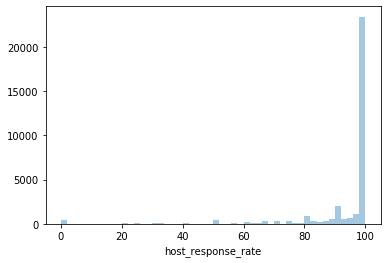

In [32]:
# check non-missing values
temp = listing_all['host_response_rate'][~listing_all['host_response_rate'].isnull()]
temp = temp.apply(lambda x: float(str(x.split('%')[0])))
print('The minimum no missing value of host_response_rate is ' + str(temp.min())) ## 0 is a resonable value for this feature. 
sns.distplot(temp, kde = False)

In [33]:
# It's reasonable to fill the NaN with 0, meaning that the host never responded. 
listing_all['host_response_rate'] = listing_all['host_response_rate'].fillna('0%').apply(lambda x: float(x.split('%')[0])/100)
listing_all['host_response_rate'].describe()

count    50599.000000
mean         0.607348
std          0.463981
min          0.000000
25%          0.000000
50%          0.930000
75%          1.000000
max          1.000000
Name: host_response_rate, dtype: float64

##### Creating new variables -- fee to price ratios

In [34]:
#Does other fees correlate with the price?-- weak positive correlation
listing_all[money_feat].corr()

,price,security_deposit,cleaning_fee,extra_people
price,1.000000,0.105689,0.163423,0.027434
security_deposit,0.105689,1.000000,0.395208,0.136597
cleaning_fee,0.163423,0.395208,1.000000,0.170177
extra_people,0.027434,0.136597,0.170177,1.000000


In [35]:
listing_all['security_deposit_to_price_ratio'] = listing_all['security_deposit']/listing_all['price']

In [36]:
listing_all['cleaning_fee_to_price_ratio'] = listing_all['cleaning_fee']/listing_all['price']

#### 5) Recode boolean features that are <i>object</i> type to <i>1/0</i>

In [37]:
boo = ['instant_bookable','require_guest_profile_picture', 'require_guest_phone_verification',
       'host_is_superhost', 'host_has_profile_pic', 'is_location_exact', 
       'host_identity_verified']

In [38]:
listing_all[boo].isnull().sum()

instant_bookable                      0
require_guest_profile_picture         0
require_guest_phone_verification      0
host_is_superhost                   563
host_has_profile_pic                563
is_location_exact                     0
host_identity_verified              563
dtype: int64

In [39]:
# re-code missing host_is_superhost host_has_profile_pic to false.
listing_all['host_is_superhost'] = listing_all['host_is_superhost'].fillna('f')

In [40]:
listing_all['host_has_profile_pic'] = listing_all['host_has_profile_pic'].fillna('f')

In [41]:
listing_all['host_identity_verified'] = listing_all['host_identity_verified'].fillna('f')

In [42]:
for c in boo:
    listing_all[c] = listing_all[c].apply(lambda x: 1 if x == 't' else 0)

#### 6) Recode and creating date features that are in <i> object </i> type

In [43]:
dt = ['first_review', 'last_review', 'host_since']

In [44]:
from datetime import datetime
for d in dt:
    listing_all[d] = pd.to_datetime(listing_all[d])

##### Create new feature for the difference between the first and last review 

In [45]:
listing_all['last_first_review'] = (listing_all['last_review'] - listing_all['first_review']).dt.days

##### Create new feature for length of being a host

In [46]:
listing_all['hosting_age'] = ( pd.to_datetime('2020-01-01') - listing_all['host_since'])

In [47]:
# update data clean log
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'Recode object type features to quantitative features and created fee to price ratio and time difference features', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after']),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'])}, index = [max(dat_clean.index)+1]))


#### 7) Convert <i>object</i> type categorical features to dummy coded variable 

In [48]:
cat = ['cancellation_policy','host_response_time','neighbourhood_group_cleansed',
       'room_type','bed_type']
# The property_type and the neighbourhood_cleansed has too many levels to be recode

In [49]:
# examine the categorical variables
for ctg in cat:
    print(listing_all[ctg].value_counts(dropna = False))

strict_14_with_grace_period    23166
flexible                       15459
moderate                       11795
super_strict_60                  107
strict                            49
super_strict_30                   23
Name: cancellation_policy, dtype: int64
within an hour        19898
NaN                   17658
within a few hours     7592
within a day           4533
a few days or more      918
Name: host_response_time, dtype: int64
Manhattan        22070
Brooklyn         20740
Queens            6196
Bronx             1215
Staten Island      378
Name: neighbourhood_group_cleansed, dtype: int64
Entire home/apt    26141
Private room       22785
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64
Real Bed         49859
Futon              280
Pull-out Sofa      235
Airbed             158
Couch               67
Name: bed_type, dtype: int64


In [50]:
for ctg in cat:
    listing_all = pd.concat([listing_all, 
                    pd.get_dummies(listing_all[ctg], prefix = ctg, prefix_sep = '_', 
                                drop_first = False, dummy_na = True)], axis=1)

In [51]:
# update data clean log
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'Recode categorical features to dummy features', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after'] ),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'] )}, index = [max(dat_clean.index)+1]))


In [52]:
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0
2,2,remove features with more than 40% of missing,50599,88,0.0,-10.0
3,3,remove features with no variance,50599,81,0.0,-7.0
4,4,Recode object type features to quantitative fe...,50599,85,0.0,4.0
5,5,Recode categorical features to dummy features,50599,114,0.0,29.0


#### 8) Remove texts that are hard to use in quantitative models

In [53]:
textcol = ['last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 
          'transit', 'house_rules','host_name', 'amenities']

In [54]:
listing_all = listing_all.drop(textcol,axis = 1 )

In [55]:
# update data clean log
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'Remove description features', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after'] ),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'] )}, index = [max(dat_clean.index)+1]))


In [56]:
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0
2,2,remove features with more than 40% of missing,50599,88,0.0,-10.0
3,3,remove features with no variance,50599,81,0.0,-7.0
4,4,Recode object type features to quantitative fe...,50599,85,0.0,4.0
5,5,Recode categorical features to dummy features,50599,114,0.0,29.0
6,6,Remove description features,50599,104,0.0,-10.0


In [57]:
non_inform = ['host_neighbourhood','neighbourhood', 'street', 'calendar_last_scraped','calendar_updated' ]

In [58]:
listing_all = listing_all.drop(non_inform, axis = 1)

In [59]:
# update data clean log
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'Remove non-informative features', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after'] ),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'] )}, index = [max(dat_clean.index)+1]))
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0
2,2,remove features with more than 40% of missing,50599,88,0.0,-10.0
3,3,remove features with no variance,50599,81,0.0,-7.0
4,4,Recode object type features to quantitative fe...,50599,85,0.0,4.0
5,5,Recode categorical features to dummy features,50599,114,0.0,29.0
6,6,Remove description features,50599,104,0.0,-10.0
7,7,Remove non-informative features,50599,99,0.0,-5.0


#### 9) Missing data

In [61]:
listing_all.isnull().mean()[listing_all.isnull().sum() != 0]

host_since                         0.011127
host_location                      0.014111
host_response_time                 0.348979
host_listings_count                0.011127
host_total_listings_count          0.011127
city                               0.002549
state                              0.000099
zipcode                            0.009190
market                             0.002036
bathrooms                          0.001008
bedrooms                           0.001245
beds                               0.002609
first_review                       0.201980
last_review                        0.201980
review_scores_rating               0.220597
review_scores_accuracy             0.221309
review_scores_cleanliness          0.221032
review_scores_checkin              0.221625
review_scores_communication        0.221249
review_scores_location             0.221704
review_scores_value                0.221684
reviews_per_month                  0.201980
security_deposit_to_price_ratio 

##### Keep observations that have non-missing value <i>bedroom</i> , <i>bathroom</i>, <i>beds</i>.

In [62]:
listing_all = listing_all.dropna(subset = ['bedrooms','bathrooms', 'beds'], how = 'any', axis = 0)

##### Impute review ratings with the average of each <i>neighborhood</i>.

In [63]:
# find the neighbourhood missing reviews for all of its entries.
nb_miss_rt = listing_all[['neighbourhood_cleansed','review_scores_rating','review_scores_accuracy',
             'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
             'review_scores_location','review_scores_value']].groupby('neighbourhood_cleansed').mean().isnull()

In [64]:
nb_miss_rt.sum(axis = 1)[nb_miss_rt.sum(axis = 1)!=0]

neighbourhood_cleansed
Fort Wadsworth    7
New Dorp          7
Woodrow           7
dtype: int64

In [65]:
listing_all['neighbourhood_cleansed'].isin( ['Fort Wadsworth','New Dorp','Woodrow']).sum()

3

In [66]:
# Remove neighbourhood missing review scores for all the properties in the area. 
listing_all = listing_all[~listing_all['neighbourhood_cleansed'].isin(['Fort Wadsworth','New Dorp','Woodrow'])]

In [67]:
rv_sco = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
          'review_scores_checkin','review_scores_communication','review_scores_location',
          'review_scores_value']

In [68]:
for rv in rv_sco:
    listing_all[rv] = listing_all[rv].fillna(listing_all.groupby(['neighbourhood_cleansed'])[rv].transform('mean'))

##### Keep observations with the <i>market</i> of New York

In [69]:
listing_all = listing_all[listing_all['market'].isin(['New York'])]


##### Keep observations with <i> price </i> being 0. 

In [70]:
# remove those with price being 0. 
listing_all = listing_all[listing_all['price']!=0]

In [71]:
# update data clean log
dat_clean = dat_clean.append(pd.DataFrame({dat_clean.columns[0] : max(dat_clean['ord']+1),
                                     dat_clean.columns[1]:'Dealing with missing data ', 
                                     dat_clean.columns[2]:listing_all.shape[0], 
                                     dat_clean.columns[3]:listing_all.shape[1],
                                     dat_clean.columns[4]:(listing_all.shape[0] - dat_clean.loc[max(dat_clean.index), 'nrow_after'] ),
                                     dat_clean.columns[5]:(listing_all.shape[1] - dat_clean.loc[max(dat_clean.index), 'ncol_after'] )}, index = [max(dat_clean.index)+1]))
dat_clean

,ord,action,nrow_after,ncol_after,nrow_changed,ncol_changed
0,0,start,50599,106,NaN,NaN
1,1,remove features of urls,50599,98,0.0,-8.0
2,2,remove features with more than 40% of missing,50599,88,0.0,-10.0
3,3,remove features with no variance,50599,81,0.0,-7.0
4,4,Recode object type features to quantitative fe...,50599,85,0.0,4.0
5,5,Recode categorical features to dummy features,50599,114,0.0,29.0
6,6,Remove description features,50599,104,0.0,-10.0
7,7,Remove non-informative features,50599,99,0.0,-5.0
8,8,Dealing with missing data,50226,99,-373.0,0.0


### 2. Investigation on the price 

#### 1) What features correlate with price?

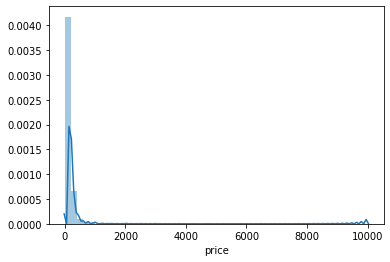

In [72]:
sns.distplot(listing_all['price'])
# strongly negtively skewed outcome variable

In [73]:
import math
listing_all['log_price'] = listing_all['price'].apply(lambda x: math.log(x,10))


In [74]:
# select possible price related features
price_feat = listing_all.select_dtypes(include=['int64', 'float64','timedelta64[ns]', 'uint8'])
price_feat.shape

(50226, 83)

In [75]:
price_feat.columns


Index(['id', 'host_id', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'requi

In [76]:
price_feat[['cancellation_policy_nan', 'neighbourhood_group_cleansed_nan', 'room_type_nan','bed_type_nan']].var()

cancellation_policy_nan             0.0
neighbourhood_group_cleansed_nan    0.0
room_type_nan                       0.0
bed_type_nan                        0.0
dtype: float64

In [77]:
price_all = price_feat.columns.to_list()
# remove redundant information
rm_list = ['host_id','host_listings_count', 'host_total_listings_count',
           'latitude', 'longitude','minimum_minimum_nights','maximum_minimum_nights', 
           'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 
           'maximum_nights_avg_ntm','number_of_reviews_ltm', 
           'calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_private_rooms',
           'calculated_host_listings_count_shared_rooms', 'security_deposit_to_price_ratio', 
           'security_deposit_to_price_ratio','cleaning_fee_to_price_ratio', 'last_first_review', 
           'hosting_age', 'cancellation_policy_flexible', 
           'host_response_time_within a few hours', 'neighbourhood_group_cleansed_Manhattan', 
           'room_type_Entire home/apt', 'bed_type_Real Bed', 
           'cancellation_policy_nan', 'neighbourhood_group_cleansed_nan', 
           'room_type_nan','bed_type_nan', 'reviews_per_month']

# dummy coded categorical variables -- reference level
# cancellation_policy -- flexible
# host_response_time -- within a few hours
# neighbourhood_group_cleansed -- Manhattan
# room_type -- Entire home/apt
# bed_type -- Real Bed

In [78]:
# remove less relevant features to prevent overfitting
#rm_list = rm_list + ['availability_30', 'availability_60', 'availability_90', 
#                     'host_identity_verified', 'require_guest_profile_picture', 'require_guest_phone_verification',
#                    'is_location_exact', 'is_location_exact']

In [81]:
price_feat_cleaned = price_feat.drop(rm_list, axis = 1)


In [82]:
price_feat_cleaned.isnull().sum()


id                                                 0
host_response_rate                                 0
host_is_superhost                                  0
host_has_profile_pic                               0
host_identity_verified                             0
is_location_exact                                  0
accommodates                                       0
bathrooms                                          0
bedrooms                                           0
beds                                               0
price                                              0
security_deposit                                   0
cleaning_fee                                       0
guests_included                                    0
extra_people                                       0
minimum_nights                                     0
maximum_nights                                     0
availability_30                                    0
availability_60                               

In [80]:
price_feat_cleaned.corr()['price'].abs().sort_values(ascending = False)


price                                              1.000000
log_price                                          0.547541
accommodates                                       0.228684
bedrooms                                           0.174331
cleaning_fee                                       0.163100
beds                                               0.161064
bathrooms                                          0.151331
room_type_Private room                             0.146453
guests_included                                    0.108914
security_deposit                                   0.106298
neighbourhood_group_cleansed_Brooklyn              0.081197
availability_30                                    0.068342
availability_365                                   0.064584
availability_60                                    0.062179
neighbourhood_group_cleansed_Queens                0.061585
availability_90                                    0.058027
review_scores_location                  

#### 2) Train and Test the ML model 


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [86]:
X = price_feat_cleaned.drop(['id', 'price', 'log_price'],axis =1)
y = price_feat_cleaned['log_price']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 101)

In [89]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm.coef_
coefs_df['abs_coefs'] = np.abs(lm.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df[0:10]

,est_int,coefs,abs_coefs
46,room_type_Shared room,-0.395943,0.395943
43,neighbourhood_group_cleansed_Staten Island,-0.270077,0.270077
40,neighbourhood_group_cleansed_Bronx,-0.232284,0.232284
45,room_type_Private room,-0.226091,0.226091
42,neighbourhood_group_cleansed_Queens,-0.196416,0.196416
41,neighbourhood_group_cleansed_Brooklyn,-0.142949,0.142949
34,cancellation_policy_super_strict_30,-0.141888,0.141888
35,cancellation_policy_super_strict_60,-0.090791,0.090791
25,review_scores_location,0.052565,0.052565
32,cancellation_policy_strict,-0.050802,0.050802


In [91]:
# test
pred = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

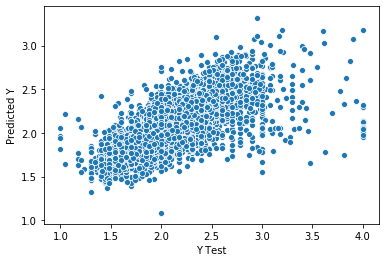

In [92]:
sns.scatterplot(y_test, pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [93]:
print("MAE:", metrics.mean_absolute_error(y_test, pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.14115556264644902
MSE: 0.03999972579046403
RMSE: 0.1999993144749852


In [94]:
print('RSqaured:', metrics.explained_variance_score(y_test, pred))

RSqaured: 0.5806545953537197


#### 3) Train a Gradient Boosting 

In [95]:
from sklearn import ensemble
from sklearn import datasets


In [97]:
# Fit regression model
params = {'n_estimators': 600, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=600,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
print("MAE:", metrics.mean_absolute_error(y_test, clf.predict(X_test)))
print("MSE:", metrics.mean_squared_error(y_test, clf.predict(X_test)))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, clf.predict(X_test))))
print('RSqaured:', metrics.explained_variance_score(y_test, clf.predict(X_test)))


MAE: 0.12848732053971465
MSE: 0.03330143835596922
RMSE: 0.18248681693746874
RSqaured: 0.6508664935587121


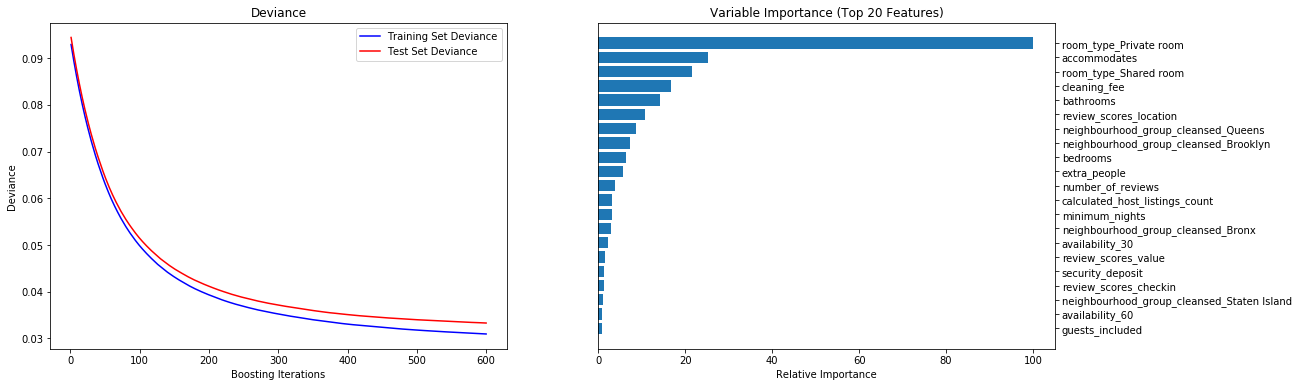

In [99]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
pos = np.arange(21) + .5
f = plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx[-21:]], align='center')
#plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx[-21:]])
#plt.yticks(pos, X_train.columns[sorted_idx])
f.yaxis.tick_right()
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top 20 Features)')
plt.show()

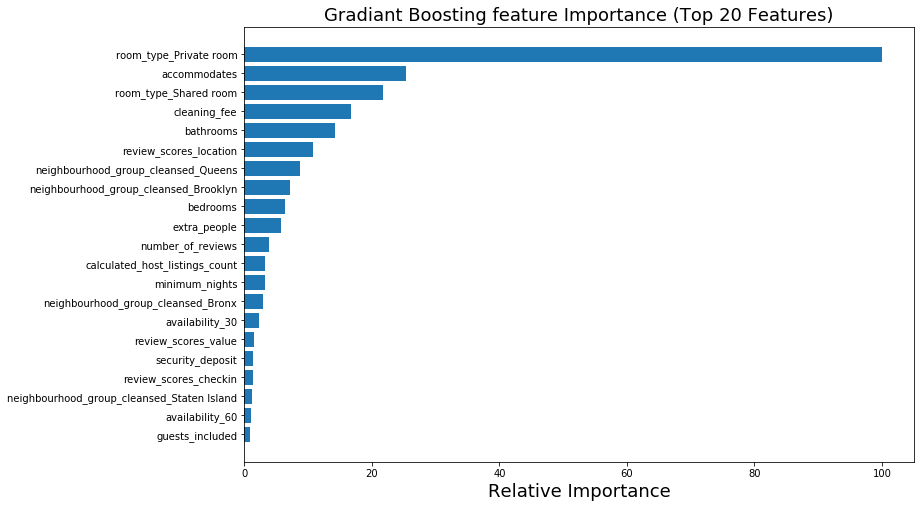

In [100]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
pos = np.arange(21) + .5

f = plt.figure(figsize = (12,8))
plt.barh(pos, feature_importance[sorted_idx[-21:]], align='center')
#plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx[-21:]])
#plt.yticks(pos, X_train.columns[sorted_idx])
#f.yaxis.tick_right()
plt.xlabel('Relative Importance', fontsize = 18)
plt.title('Gradiant Boosting feature Importance (Top 20 Features)', fontsize = 18)
plt.show()
f.savefig('feat_importance.png', bbox_inches='tight')

#### 4) Insights 

##### * Location and Price 

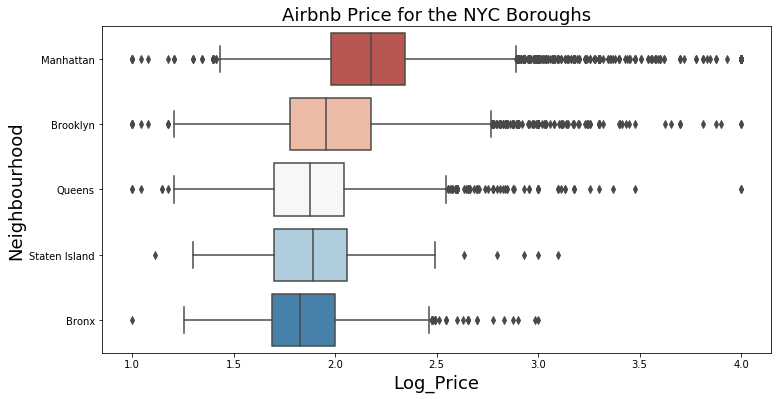

In [102]:
p0 = plt.figure(figsize = (12,6))
sns.boxplot(y = 'neighbourhood_group_cleansed', x = 'log_price' ,data = listing_all, 
            orient= 'h', palette = 'RdBu')
plt.xlabel('Log_Price', fontsize = 18)
plt.ylabel('Neighbourhood', fontsize = 18)
plt.title('Airbnb Price for the NYC Boroughs', fontsize = 18);
plt.savefig('price_boroughs')

In [103]:
listing_all.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending = False)[0:20]

neighbourhood_cleansed
Manhattan Beach      1098.800000
Theater District      685.247557
Sea Gate              608.142857
Country Club          525.000000
Prince's Bay          506.666667
Tribeca               413.389744
SoHo                  370.039437
Battery Park City     367.642857
Midtown               321.598279
Flatiron District     320.189189
Bayside               313.549020
Willowbrook           309.000000
NoHo                  287.430556
Little Italy          286.572727
Civic Center          275.750000
Neponsit              274.666667
Riverdale             265.555556
West Village          264.633638
Greenwich Village     260.765499
Lower East Side       255.626993
Name: price, dtype: float64

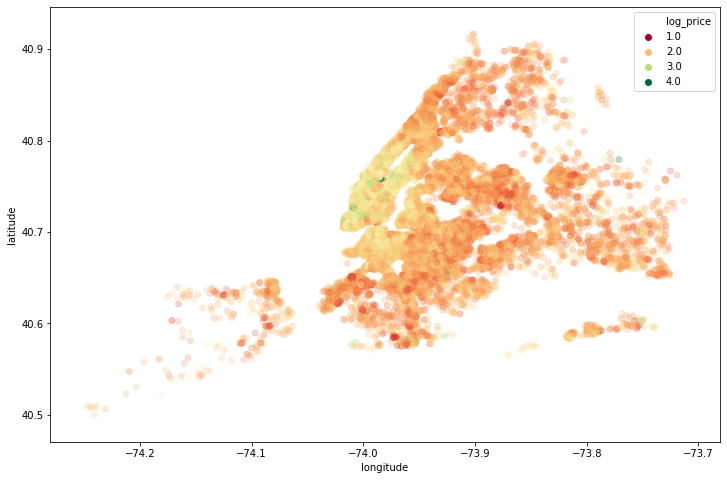

In [104]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',
                data=listing_all,hue='log_price',
                palette='RdYlGn',edgecolor=None,alpha=0.2)

In [105]:
ruh_m = plt.imread('New_York_City.PNG', 'PNG')

In [106]:
BBox = ((listing_all.longitude.min()+0.006,   listing_all.longitude.max()+0.006,      
         listing_all.latitude.min()-0.005, listing_all.latitude.max()-0.005))
BBox

(-74.24186999999999, -73.70699, 40.49479, 40.91186)

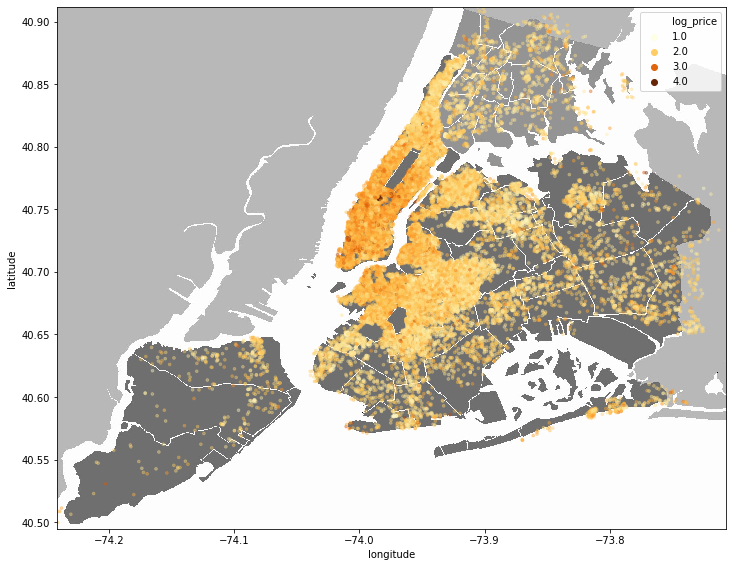

In [107]:
fig, ax = plt.subplots(figsize = (12,11))
sns.scatterplot(x='longitude',y='latitude',
                data=listing_all,hue='log_price',
                palette='YlOrBr',edgecolor=None,alpha=0.4, s=8)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0,extent = BBox, aspect= 'equal');


In [108]:
fig.savefig('mapped.png')

##### * Room Type and Price


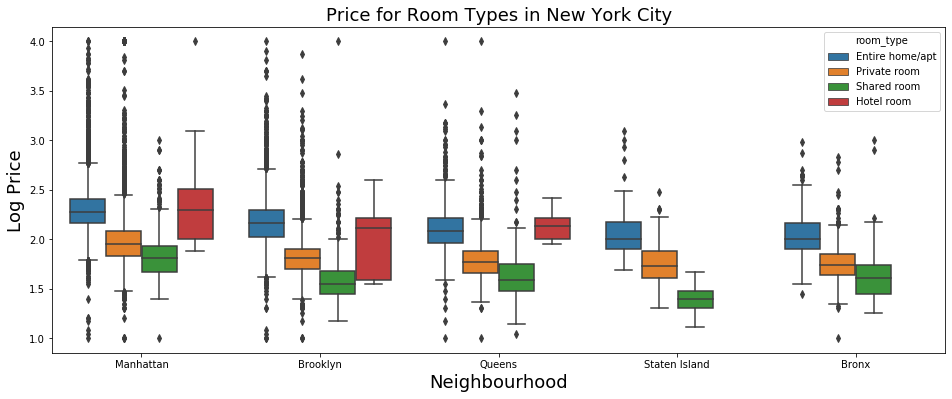

In [109]:
p1 = plt.figure(figsize = (16,6))
sns.boxplot(x = 'neighbourhood_group_cleansed', y = 'log_price' ,data = listing_all, hue = 'room_type')
plt.xlabel('Neighbourhood', fontsize = 18)
plt.ylabel('Log Price', fontsize = 18)
#plt.legend('Room Type')
plt.title('Price for Room Types in New York City', fontsize = 18);
plt.savefig('Price_roomtype_boroughs.png')

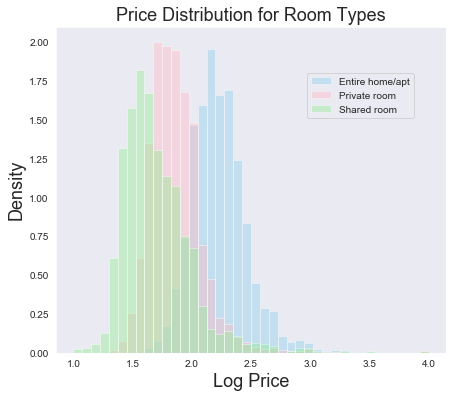

In [110]:
sns.set_style("dark")
axs = plt.figure(figsize = (7,6))
sns.distplot( listing_all.log_price[listing_all['room_type'] == 'Entire home/apt'] , 
             color="skyblue", label="Entire home/apt", bins = 40, norm_hist = True, kde = False)
sns.distplot( listing_all.log_price[listing_all['room_type'] == 'Private room'] , 
             color="lightpink", label="Private room", bins = 40, norm_hist = True, kde = False)
sns.distplot( listing_all.log_price[listing_all['room_type'] == 'Shared room'] , 
             color="lightgreen", label="Shared room", bins = 40, norm_hist = True, kde = False)
#sns.distplot( listing_all.log_price[listing_all['room_type'] == 'Hotel room'] , 
#             color="orange", label="Hotel room", bins = 40, kde = True)

axs.legend(loc='center left', bbox_to_anchor=(0.6, 0.7), ncol=1)
plt.xlabel('Log Price', fontsize = 18)
plt.ylabel('Density', fontsize = 18)
plt.title('Price Distribution for Room Types', fontsize = 18)
plt.savefig('Density_price_roomtype.png')

##### * Cancellation Policy and Price 

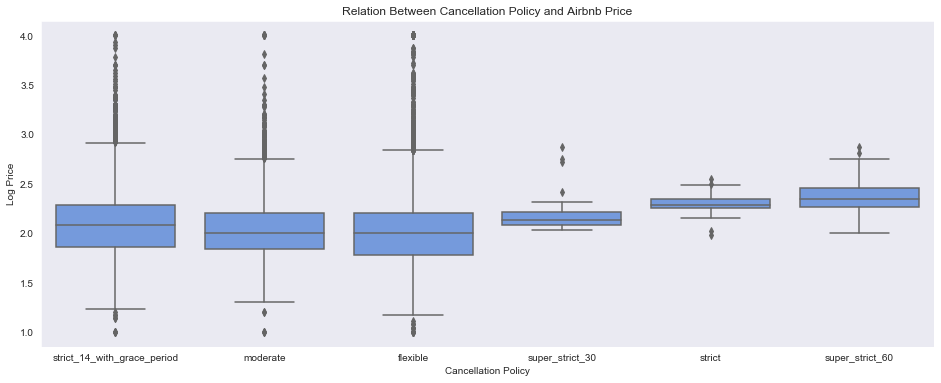

In [111]:
p3 = plt.figure(figsize = (16,6))
sns.boxplot(x = 'cancellation_policy', y = 'log_price' ,data = listing_all, 
            color = 'cornflowerblue')
plt.xlabel('Cancellation Policy')
plt.ylabel('Log Price')
plt.title('Relation Between Cancellation Policy and Airbnb Price');

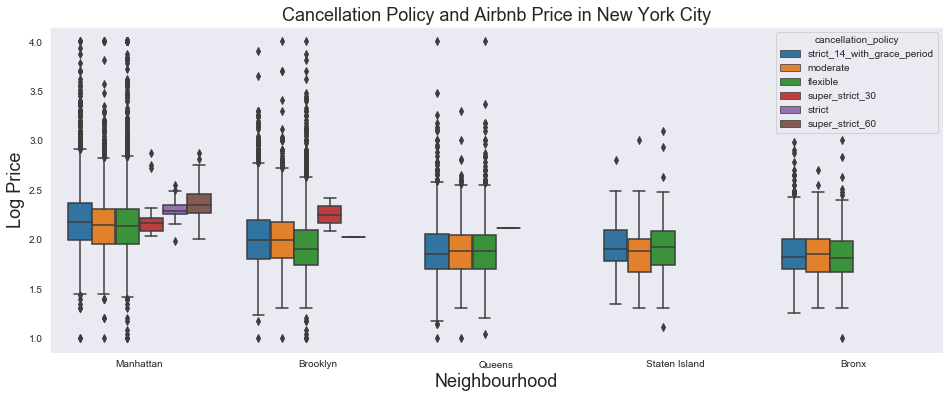

In [112]:
p2 = plt.figure(figsize = (16,6))
sns.boxplot(x = 'neighbourhood_group_cleansed', y = 'log_price' ,data = listing_all, hue = 'cancellation_policy')
plt.xlabel('Neighbourhood', fontsize = 18)
plt.ylabel('Log Price', fontsize = 18)
#plt.legend('Room Type')
plt.title('Cancellation Policy and Airbnb Price in New York City', fontsize = 18);

##### * Review Ratings and Price 

In [113]:
mx_price_rt = price_feat_cleaned[['log_price','review_scores_rating','review_scores_accuracy','review_scores_cleanliness' ,'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].corr()

In [114]:
mx_price_rt

,log_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
log_price,1.000000,0.064462,0.026509,0.090817,0.012393,0.030119,0.183289,-0.025137
review_scores_rating,0.064462,1.000000,0.755379,0.715156,0.596541,0.667223,0.468549,0.765523
review_scores_accuracy,0.026509,0.755379,1.000000,0.613005,0.575744,0.614675,0.434633,0.696563
review_scores_cleanliness,0.090817,0.715156,0.613005,1.000000,0.448400,0.473953,0.347708,0.616135
review_scores_checkin,0.012393,0.596541,0.575744,0.448400,1.000000,0.676865,0.387041,0.534090
review_scores_communication,0.030119,0.667223,0.614675,0.473953,0.676865,1.000000,0.418433,0.584319
review_scores_location,0.183289,0.468549,0.434633,0.347708,0.387041,0.418433,1.000000,0.459982
review_scores_value,-0.025137,0.765523,0.696563,0.616135,0.534090,0.584319,0.459982,1.000000


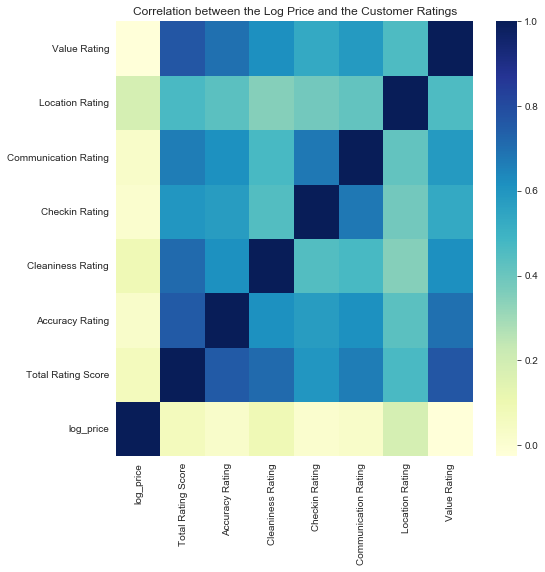

In [115]:
plt.figure(figsize = (8,8))
sns.heatmap(mx_price_rt, 
            xticklabels = False, yticklabels = False, cmap="YlGnBu")
pos = np.arange(0,9)+0.5
plt.yticks(pos,['log_price', 'Total Rating Score', 'Accuracy Rating', 'Cleaniness Rating',
           'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']);
plt.xticks(pos,['log_price', 'Total Rating Score', 'Accuracy Rating', 'Cleaniness Rating',
           'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating'], rotation=90);
plt.xlim(0,8);
plt.ylim(0,8);
plt.title('Correlation between the Log Price and the Customer Ratings');


##### * Number of Listings and Price 

In [116]:
listing_all['bedrooms'].value_counts()
listing_all_bed = listing_all[listing_all['bedrooms']<=8]


Text(1736.0749999999998, 0.5, 'Log Price')

<Figure size 1152x432 with 0 Axes>

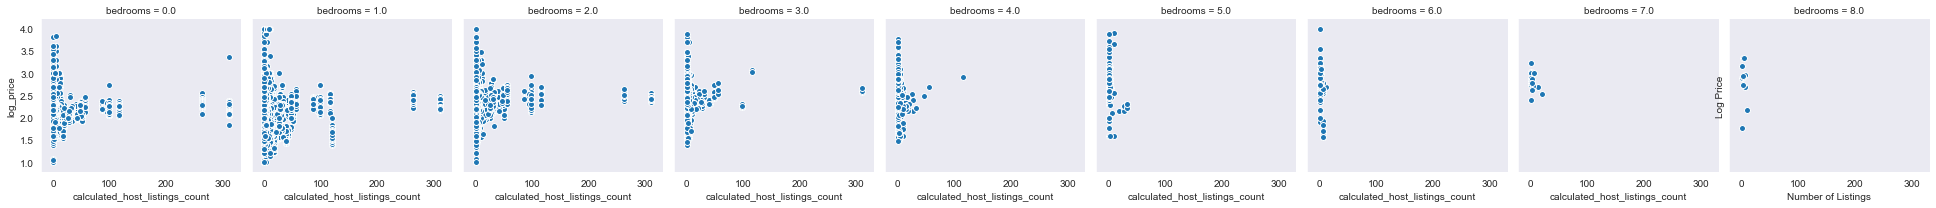

In [118]:
p3 = plt.figure(figsize = (16,6))
g = sns.FacetGrid(data = listing_all_bed, col = 'bedrooms')
g = g.map(plt.scatter, 'calculated_host_listings_count', 'log_price', edgecolor="w")
plt.xlabel('Number of Listings')
plt.ylabel('Log Price')
#plt.legend('Room Type')
#plt.title('Relation Between Cancellation Policy and Airbnb Price in New York City');

##### * Bed Type and Price

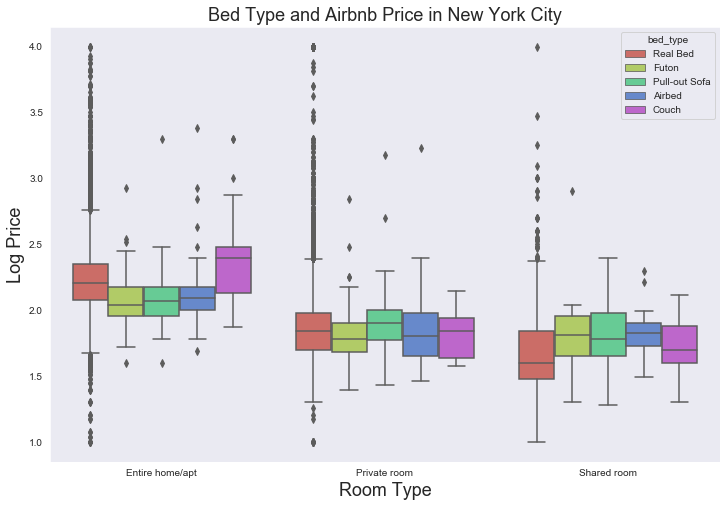

In [119]:
listing_all_bed_room = listing_all[listing_all['room_type'] != 'Hotel room']
p4 = plt.figure(figsize = (12,8))
sns.boxplot(x = 'room_type', y = 'log_price' ,data = listing_all_bed_room, hue = 'bed_type', 
            orient ='v', palette = 'hls')
plt.xlabel('Room Type', fontsize = 18)
plt.ylabel('Log Price', fontsize = 18)
#plt.legend('Room Type')
plt.title('Bed Type and Airbnb Price in New York City', fontsize = 18);
plt.savefig('Bed_room_type.png')

### 3.  Investigation on Review Ratings 

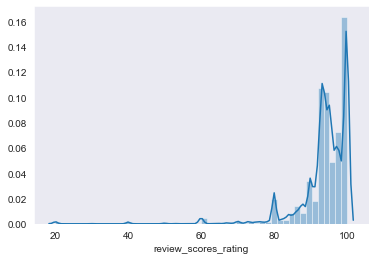

In [120]:
sns.distplot(listing_all['review_scores_rating'])

In [121]:
# select possible price related features
rt_feat = listing_all.select_dtypes(include=['int64', 'float64','timedelta64[ns]', 'uint8'])
rt_feat.shape


(50226, 83)

In [122]:
rt_feat.columns

Index(['id', 'host_id', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'requi

In [123]:
rt_all = rt_feat.columns.to_list()
# remove redundant information
rt_rm_list = ['host_id','host_listings_count', 'host_total_listings_count',
           'latitude', 'longitude','minimum_minimum_nights','maximum_minimum_nights', 
           'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 
           'maximum_nights_avg_ntm','number_of_reviews_ltm', 
           'calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_private_rooms',
           'calculated_host_listings_count_shared_rooms', 
           'cancellation_policy_flexible', 
           'host_response_time_within a few hours', 'neighbourhood_group_cleansed_Manhattan', 
           'room_type_Entire home/apt', 'bed_type_Real Bed', 
           'cancellation_policy_nan', 'neighbourhood_group_cleansed_nan', 
           'room_type_nan','bed_type_nan', 'security_deposit',
       'cleaning_fee', 'reviews_per_month', 'last_first_review']

# dummy coded categorical variables -- reference level
# cancellation_policy -- flexible
# host_response_time -- within a few hours
# neighbourhood_group_cleansed -- Manhattan
# room_type -- Entire home/apt
# bed_type -- Real Bed

In [124]:
rt_feat_cleaned = rt_feat.drop(rt_rm_list, axis = 1)


In [125]:
rt_feat_cleaned.isnull().mean().sort_values(ascending=False)[0:10]

hosting_age                    0.01111
log_price                      0.00000
review_scores_value            0.00000
review_scores_communication    0.00000
review_scores_checkin          0.00000
review_scores_cleanliness      0.00000
review_scores_accuracy         0.00000
review_scores_rating           0.00000
number_of_reviews              0.00000
availability_365               0.00000
dtype: float64

In [126]:
rt_feat_cleaned = rt_feat_cleaned.dropna(subset = ['hosting_age'], axis = 0, how = 'any')
rt_feat_cleaned.shape

(49668, 55)

#### 1). Train and test ML models

In [127]:
rt_X = price_feat_cleaned.drop(['id', 'log_price', 'review_scores_rating'],axis =1)
rt_y = price_feat_cleaned['review_scores_rating']

In [128]:
Xrt_train, Xrt_test, yrt_train, yrt_test = train_test_split(rt_X, rt_y, test_size =0.3, random_state = 101)

In [129]:
lm = LinearRegression()
lm.fit(Xrt_train, yrt_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
# prediction
pred_rt = lm.predict(Xrt_test)


Text(0, 0.5, 'Predicted Y')

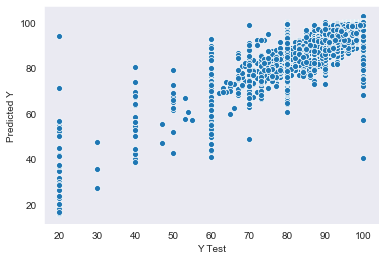

In [131]:
sns.scatterplot(yrt_test, pred_rt)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [133]:
print("MAE:", metrics.mean_absolute_error(yrt_test, pred_rt))
print("MSE:", metrics.mean_squared_error(yrt_test, pred_rt))
print("RMSE:", np.sqrt(metrics.mean_squared_error(yrt_test, pred_rt)))
print('RSqaured:', metrics.explained_variance_score(yrt_test, pred_rt))


MAE: 2.1712057957568565
MSE: 14.65759361187457
RMSE: 3.828523685688071
RSqaured: 0.7402817521067055


In [134]:
coefs_df_rt = pd.DataFrame()
coefs_df_rt['est_int'] = Xrt_train.columns
coefs_df_rt['coefs'] = lm.coef_
coefs_df_rt['abs_coefs'] = np.abs(lm.coef_)
coefs_df_rt = coefs_df_rt.sort_values('abs_coefs', ascending=False)
coefs_df_rt[0:20]

,est_int,coefs,abs_coefs
26,review_scores_value,2.647914,2.647914
21,review_scores_accuracy,2.345791,2.345791
22,review_scores_cleanliness,2.277312,2.277312
24,review_scores_communication,2.018577,2.018577
32,cancellation_policy_strict,-1.044859,1.044859
35,cancellation_policy_super_strict_60,-0.801703,0.801703
44,room_type_Hotel room,-0.619096,0.619096
23,review_scores_checkin,0.572019,0.572019
47,bed_type_Airbed,-0.560326,0.560326
0,host_response_rate,0.532952,0.532952


#### 2)  insights -- cancellation policy and price

(70, 105)

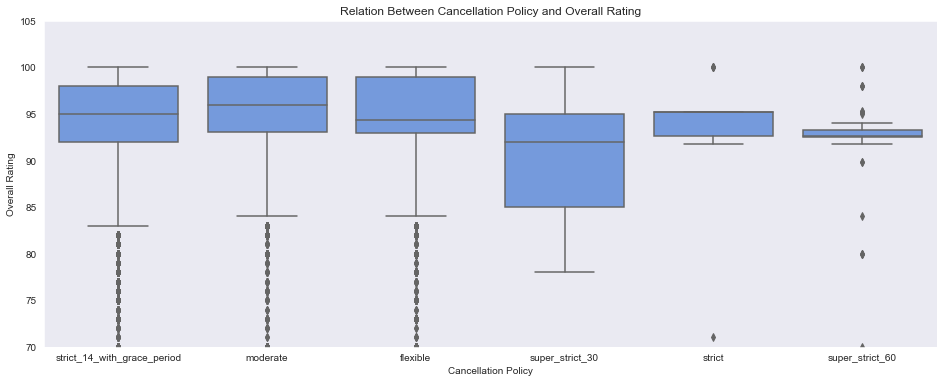

In [135]:
p5 = plt.figure(figsize = (16,6))
sns.boxplot(x = 'cancellation_policy', y = 'review_scores_rating' ,data = listing_all, 
            color = 'cornflowerblue')
plt.xlabel('Cancellation Policy')
plt.ylabel('Overall Rating')
plt.title('Relation Between Cancellation Policy and Overall Rating');
plt.ylim(70,105)

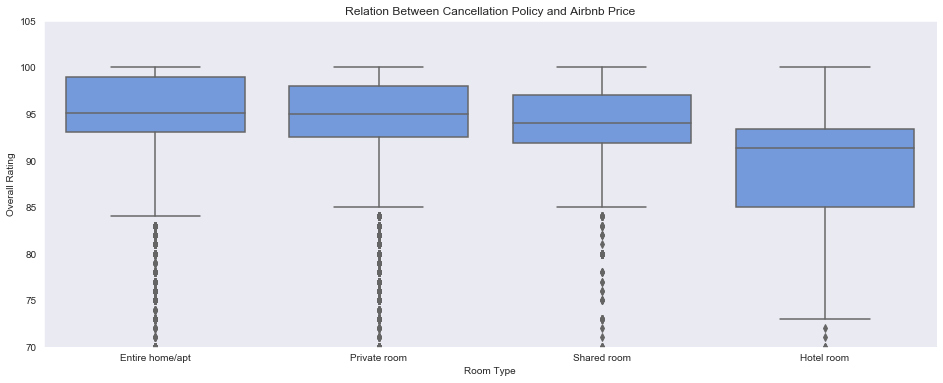

In [136]:
p6 = plt.figure(figsize = (16,6))
sns.boxplot(x = 'room_type', y = 'review_scores_rating' ,data = listing_all, 
            color = 'cornflowerblue')
plt.xlabel('Room Type')
plt.ylabel('Overall Rating')
plt.title('Relation Between Cancellation Policy and Airbnb Price');
plt.ylim(70,105);

In [137]:
#### End of Code